# 400_analysis_RQ3

## Purpose
In this notebook we will be doing the basic analysis of our second RQ:

- "Does past experience of a founder effect the amount of funding received by a startup?"

We proceed to analyse the following details:
- Gender analysis of experienced and non-experienced founders
- Average funding received by experienced versus non-experienced founders
- Percentage change of funding for experienced founders
- 1st startup of experienced founder versus non-experienced founder only startup.


## Datasets
* _Input_: 300_analysis_RQ2.pkl
* _Output_: None

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx
from matplotlib.ticker import FuncFormatter
pd.set_option('display.max_columns', None)
module_path = os.path.abspath(os.path.join('../../data/..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%matplotlib inline

In [2]:
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_palette("muted")
sns.set_context("poster")

# Text, lines, and markers...
plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.grid'] = True
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['lines.markersize'] = 15
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.fontsize'] = 22
plt.rcParams['patch.force_edgecolor'] = True

## Importing dataset 2

This is the same dataset we used for our analysis of RQ2. It contains information about each founder like their education and also details about the startup they founded. As mentioned in previous notebooks, the reason there are multiple person instances in our dataset is because: 
- A duplicate person instance if they have founded multiple companies.
- A duplicate person instance if they have changed positions in the same company.
- A duplicate person instance if they have attain another degree/change institution while at the same company.

However, we do not see the need of merging these rows together as they would store too much information. Not only this, having the rows seperated makes it easier for our analysis of this RQ when looking at the Highest Degree and Institutions attended by the founders.

In [3]:
founders_df_raw = pd.read_pickle('../../data/analysis/300_analysis_RQ2.pkl')
founders_df_raw.shape

(44711, 55)

In [4]:
founders_df_raw.head(5)

,first_name,last_name,gender,company_name,funding_rounds,funding_total_usd,primary_role,country_code,state_code,city,title,job_type,subject,degree_type,person_uuid,degree_uuid,institution_uuid,org_uuid,Highest_Degree,Administrative Services,Advertising,Agriculture and Farming,Biotechnology,Clothing and Apparel,Commerce and Shopping,Community and Lifestyle,Consumer Goods,Content and Publishing,Design,Education,Energy,Events,Food and Beverage,Government and Military,Hardware,Health Care,Manufacturing,Media and Entertainment,Music and Audio,Natural Resources,Navigation and Mapping,Platforms,Privacy and Security,Professional Services,Real Estate,Sales and Marketing,Science and Engineering,Sports,Sustainability,Transportation,Travel and Tourism,Video,Technology,Finance,Communication
0,Steve,Wozniak,male,Apple,4,6.150250e+09,company,USA,CA,Cupertino,Co-founder,executive,EE & CS,bs,f3abe539-8db3-57e4-0f4d-de54a78eaf68,fe3eb345-b465-84ad-45d7-448f8f7a44e5,Berkeley,7063d087-96b8-2cc1-ee88-c221288acc2a,Bachelors,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Kevin,Harvey,male,Apple,4,6.150250e+09,company,USA,CA,Cupertino,Founder,executive,Engineering,bs,e7f5c146-66c5-fba4-64cb-8ffd422899d8,0dee09e8-13b6-50ee-3e17-1343036b2eed,c3144da5-8618-2e95-3a13-60417220da5e,7063d087-96b8-2cc1-ee88-c221288acc2a,Bachelors,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Armas,Markkula,male,Apple,4,6.150250e+09,company,USA,CA,Cupertino,Founder,executive,Electrical Engineering,bs,56e8a800-5c37-7599-5eb3-b815aa6acd30,29b2a7bc-4628-0e5d-53d1-d0af77d3de33,867f0af5-a1d0-143d-bbed-5cc252ca40d6,7063d087-96b8-2cc1-ee88-c221288acc2a,Masters,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Armas,Markkula,male,Apple,4,6.150250e+09,company,USA,CA,Cupertino,Founder,executive,Electrical Engineering,ms,56e8a800-5c37-7599-5eb3-b815aa6acd30,9da52706-0933-81f3-5be3-5ae30747612e,867f0af5-a1d0-143d-bbed-5cc252ca40d6,7063d087-96b8-2cc1-ee88-c221288acc2a,Masters,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Kristee,Rosendahl,female,Apple,4,6.150250e+09,company,USA,CA,Cupertino,"Designer, Art Director, Human Interface Co-fou...",employee,Design,ba,035e9cc5-d2a4-9298-7488-c348527a5d1a,0c2be7d4-47cd-8758-e668-34593c6c605f,Stanford,7063d087-96b8-2cc1-ee88-c221288acc2a,Bachelors,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Defining an experienced founder

The first point of action for this RQ is defining what an experienced founder is. We have decided that it is someone who has founded more than one startup. Therefore, a founder is defined as inexperienced if they have only found one startup. 

**First piece of analysis...**

#### How many experienced and non experienced founders are in our dataset?

To do this we will need to group our raw founders dataframe by the unique person identifier and their unique organisation identifier. We will then aggergate the first instance of the organisations funding total. We are grouping this raw dataframe for the reasons stated when importing this dataset at the start of the notebook.

In [5]:
# grouping raw founders dataframe by person_uuid and org_uuid. Aggergating gender of person and total funding for grouped organisation
founders_df = founders_df_raw.groupby(['person_uuid','org_uuid'],as_index=False).agg({'funding_total_usd':'first', 'gender':'first'})
founders_df = founders_df[founders_df['gender'] != 'not_provided']
founders_df.head(5)

,person_uuid,org_uuid,funding_total_usd,gender
0,00026df9-9254-269d-40b1-549e9529550d,d2d0cb83-b874-c5d7-c7f7-fb77613cc95b,1016992.0,male
1,000497ac-d3f9-7969-6c8b-b4050c8efc04,14658850-0cc9-15f8-62f3-a8c532ea6c61,8521954.0,male
2,000575b8-eac0-66b1-2a16-03c08c2b9f66,d2de0c01-397d-b4f1-8575-9b5e74e6b6b8,30000.0,male
3,0005da7e-2311-9002-7756-ed2f2734e057,2aec3826-0f75-1f21-326a-5dbca9d5ff15,7387100.0,male
4,0005da7e-2311-9002-7756-ed2f2734e057,bd4c4326-ef34-d5d9-b689-0c0b0a6ba03c,3428769.0,male


**Next step...**

Looking at the value counts of people in the dataset will tell us the highest number of startups founded by a person in our dataset.

In [6]:
founder_counts = founders_df.person_uuid.value_counts()
founder_counts.head(5)

6171f0b6-e39f-247f-1290-cfa84781e4c8    15
396dc987-fa6b-d5db-c6da-487576633993    12
f9060a62-278f-5ab9-ca18-3f4a2a7b6ba7    10
a16abeb6-b37a-ccdd-34ab-8129006d1ef2     9
fe7c3d15-3469-e0e1-3b31-f4cb8d0b90a6     8
Name: person_uuid, dtype: int64

**A glimpse of the Top 2 most experienced founders...**

Note: All information discussed is freely available on CrunchBase.com

In [7]:
founders_df_raw[founders_df_raw['person_uuid']=='6171f0b6-e39f-247f-1290-cfa84781e4c8'].head(1)

,first_name,last_name,gender,company_name,funding_rounds,funding_total_usd,primary_role,country_code,state_code,city,title,job_type,subject,degree_type,person_uuid,degree_uuid,institution_uuid,org_uuid,Highest_Degree,Administrative Services,Advertising,Agriculture and Farming,Biotechnology,Clothing and Apparel,Commerce and Shopping,Community and Lifestyle,Consumer Goods,Content and Publishing,Design,Education,Energy,Events,Food and Beverage,Government and Military,Hardware,Health Care,Manufacturing,Media and Entertainment,Music and Audio,Natural Resources,Navigation and Mapping,Platforms,Privacy and Security,Professional Services,Real Estate,Sales and Marketing,Science and Engineering,Sports,Sustainability,Transportation,Travel and Tourism,Video,Technology,Finance,Communication
6321,John,Donovan,male,Open Environment Corporation,2,870578950.0,company,USA,MA,Cambridge,Co-founder/Chairman,executive,unknown,bs,6171f0b6-e39f-247f-1290-cfa84781e4c8,2c0c8633-511c-794b-2362-5578006bf075,fd3759ee-9f14-b6d9-03fb-173ce84dc70d,2c46049d-baf5-af92-7ab8-0d121fe83068,PhD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


John Donovan has founded the most amount of startups in our dataset at a grand total of 15. He is a decorated businessman and is also a former professor at MIT. He has actually founded 26 companies in total, however, CrunchBase has only provided funding data on 15 of these.

In [8]:
founders_df_raw[founders_df_raw['person_uuid']=='396dc987-fa6b-d5db-c6da-487576633993'].head(1)

,first_name,last_name,gender,company_name,funding_rounds,funding_total_usd,primary_role,country_code,state_code,city,title,job_type,subject,degree_type,person_uuid,degree_uuid,institution_uuid,org_uuid,Highest_Degree,Administrative Services,Advertising,Agriculture and Farming,Biotechnology,Clothing and Apparel,Commerce and Shopping,Community and Lifestyle,Consumer Goods,Content and Publishing,Design,Education,Energy,Events,Food and Beverage,Government and Military,Hardware,Health Care,Manufacturing,Media and Entertainment,Music and Audio,Natural Resources,Navigation and Mapping,Platforms,Privacy and Security,Professional Services,Real Estate,Sales and Marketing,Science and Engineering,Sports,Sustainability,Transportation,Travel and Tourism,Video,Technology,Finance,Communication
2878,Noubar,Afeyan,male,"Joule Unlimited Technologies, Inc.",4,190000000.0,company,USA,MA,Bedford,Co-Founder,executive,Biochemical Engineering,phd,396dc987-fa6b-d5db-c6da-487576633993,5e3b1f9e-0149-f4e9-6038-fce73641381f,MIT,0b776b08-3636-cac5-0d83-72e9e0c26486,PhD,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


During Noubar Afeyan 28-year career as inventor, entrepreneur, CEO and venture capitalist, Noubar has co-founded and helped build over 35 successful life science and technology startups. 

**Next Step of Analysis...**

In order for us to see how many experienced founders there are, we simply just have to find the size of the series created above when values are greater than 1.

In [9]:
experienced = (founder_counts > 1)
founder_counts[experienced].size

2635

In [10]:
founder_counts[~experienced].size

24099

**Next Step of Analysis...**

It would be interesting to see the mean number of companies founded by an experienced founder.

In [11]:
round(founder_counts.mean())

1

In [12]:
round(founder_counts[experienced].mean())

2

This is not a surprising result. The average number of startups founded by an experienced founder was 2.

**Overall counts of Experienced and Non-Experienced Founders....**

In [13]:
exp_compare_series = pd.Series({'exp':founder_counts[experienced].size, 'non_exp':founder_counts[~experienced].size})
exp_compare_series

exp         2635
non_exp    24099
dtype: int64

**Plotting these values results in...**

Text(0,0.5,'Count')

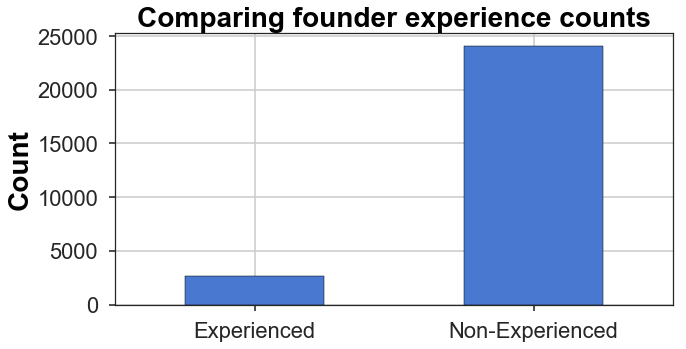

In [14]:
exp_compare_series.plot.bar(figsize=(10,5))
plt.xticks(np.arange(2), ('Experienced', 'Non-Experienced'), rotation=0)
plt.title("Comparing founder experience counts")
plt.ylabel("Count")

This piece of analysis is interesting as we can see the sample size we have of experienced founders is very small in comparison to that of non-experienced founders.

### Gender analysis of Experienced and Non-Experienced founders
We will be looking at the gender ratio for founders with different experience.

In [15]:
# this experienced bool condition allows us to only group founders who have a group size > 1 when used as a df mask
experienced = founders_df.groupby('person_uuid',sort=False)["person_uuid"].transform(len) > 1
# grouping the founders using the experienced boolean condition and aggergating their gender.
expf_df = founders_df[experienced].groupby('person_uuid').agg({'gender':'first'})
expf_df.shape

(2635, 1)

**Looking at the counts of the genders of experienced founders...**

In [16]:
exp_gender = expf_df.gender.value_counts()
exp_gender

male      2447
female     188
Name: gender, dtype: int64

**Plotting these values results in...**

Text(0.5,1,'Experienced Founders')

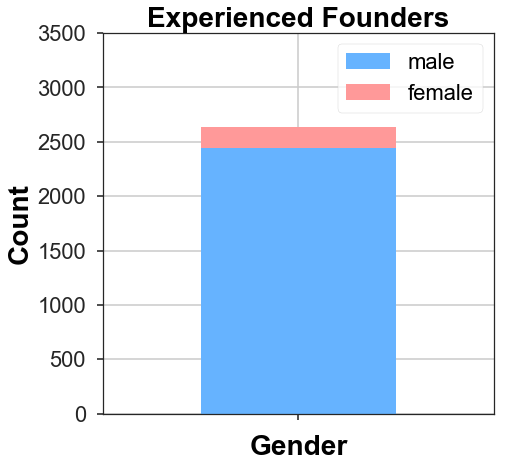

In [17]:
pd.DataFrame(exp_gender).T.plot.bar(stacked=True, figsize=(7,7), color=['#66b3ff','#ff9999'], edgecolor='none')
plt.ylim(0,3500)
plt.legend(frameon=True)
plt.xticks(np.arange(1),(''), rotation=0)
plt.ylabel("Count")
plt.xlabel("Gender")
plt.title("Experienced Founders")

As seen in previous analysis of RQ2, males dominate the gender split.

**Next...**

In [18]:
founders_df_raw.Highest_Degree.unique()

array(['Bachelors', 'Masters', 'Juris', 'PhD', 'Diploma', 'certificate',
       'Doctorate', 'Executive', 'Honors'], dtype=object)

In [19]:
# using the experienced boolean condition again, negating it this time, grouping non-experienced founders and aggregating gender
nexpf_df = founders_df[~experienced].groupby('person_uuid').agg({'gender':'first'})
nexpf_df.shape

(24099, 1)

**Looking at the counts of the genders of Non-Experienced Founders...**

In [20]:
nexp_gender = nexpf_df.gender.value_counts()
nexp_gender

male      20619
female     3463
Name: gender, dtype: int64

**Plotting these values results in...**

Text(0.5,1,'Non-Experienced Founders')

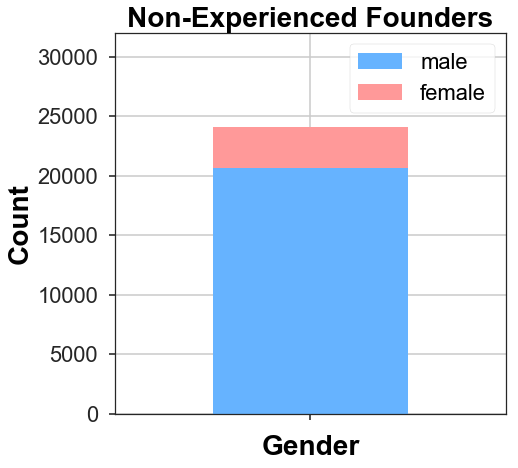

In [21]:
pd.DataFrame(nexp_gender).T.plot.bar(stacked=True, figsize=(7,7), color=['#66b3ff','#ff9999'], edgecolor='none')
plt.ylim(0,32000)
plt.legend(frameon=True)
plt.xticks(np.arange(1),(''), rotation=0)
plt.ylabel("Count")
plt.xlabel("Gender")
plt.title("Non-Experienced Founders")

We can see the extent of which males dominate Non-Experienced founders by compared to females.

## Average funding attained by Experienced and Non-Experienced Founders
Next we will investigate the average funding of experienced founders vs non-experienced founders

**Calculating the mean funding of experienced founders...**

In [22]:
founders_df[experienced].funding_total_usd.mean()

61355340.57433009

**Saving mean value into variable and dividing it to get value in terms of millions...**

In [23]:
val1 = founders_df[experienced].funding_total_usd.mean()
val1 = val1/1000000 # division to get in terms of millions
val1

61.35534057433009

**Calculating the mean funding of non-experienced founders...**

In [24]:
founders_df[~experienced].funding_total_usd.mean()

34135466.084028386

**Saving mean value into variable and dividing it to get value in terms of millions...**

In [25]:
val2 = founders_df[~experienced].funding_total_usd.mean()
val2 = val2/1000000 # division to get in terms of millions
val2

34.13546608402839

**Plotting these values results in...**

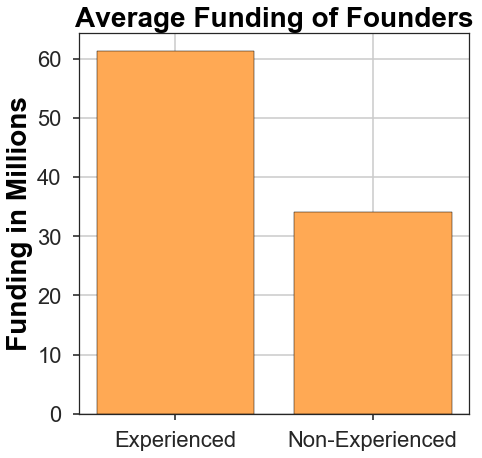

In [26]:
x = np.arange(2)
means = [val1,val2]
plt.figure(figsize=(7,7))
plt.bar(x, means, color='#ffa954')
plt.xticks(x, ('Experienced','Non-Experienced'))
plt.title("Average Funding of Founders")
plt.ylabel("Funding in Millions")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

### Experienced founders funding percentage change

In this section we will look at the percentage change in funding of experienced founders. There is no need to filter non-experienced founders in this analysis from the original founders dataframe. 

In [27]:
# grouping by unique person identifier and finding percentage change of funding.
founders_df['pct'] = founders_df.groupby('person_uuid').funding_total_usd.pct_change()
founders_df.head(10)

,person_uuid,org_uuid,funding_total_usd,gender,pct
0,00026df9-9254-269d-40b1-549e9529550d,d2d0cb83-b874-c5d7-c7f7-fb77613cc95b,1016992.0,male,NaN
1,000497ac-d3f9-7969-6c8b-b4050c8efc04,14658850-0cc9-15f8-62f3-a8c532ea6c61,8521954.0,male,NaN
2,000575b8-eac0-66b1-2a16-03c08c2b9f66,d2de0c01-397d-b4f1-8575-9b5e74e6b6b8,30000.0,male,NaN
3,0005da7e-2311-9002-7756-ed2f2734e057,2aec3826-0f75-1f21-326a-5dbca9d5ff15,7387100.0,male,NaN
4,0005da7e-2311-9002-7756-ed2f2734e057,bd4c4326-ef34-d5d9-b689-0c0b0a6ba03c,3428769.0,male,-0.535844
5,00065f25-101a-bfe2-d79c-a172af342c70,6663f9d3-e6ab-348f-66c7-cafc00ce01a8,50000.0,male,NaN
6,00065f25-101a-bfe2-d79c-a172af342c70,a1102c6c-1bc4-b6aa-c5f2-6c34bd4b2370,18100000.0,male,361.000000
7,000792fb-3022-cac3-eea5-a93a49150727,7b224a36-b7b4-d02f-bf76-b4ac9ba085ca,11920000.0,male,NaN
8,00082be1-4c28-c41f-6147-92d0e12629c8,000ad7a8-b868-f301-5f00-2a3361288fc9,25200000.0,female,NaN
9,00086acf-adf2-b9cc-e600-442bfba4412d,fcf35538-c297-85aa-4fd8-230d4a64125a,20000.0,male,NaN


**Next Step of Analysis...**

Using the 'pct' field we previously transformed, we will find the mean percentage change of funding for an experienced founder.

In [28]:
founders_df[~founders_df.pct.isnull()]['pct'].mean()

32.03965925898116

Looking at the max value in our 'pct' field

In [29]:
founders_df[~founders_df.pct.isnull()].pct.max()

14969.059880239522

Comparing to this the min value in the 'pct' field..

In [30]:
founders_df[~founders_df.pct.isnull()].pct.min()

-0.9999830767219503

In conclusion from this analysis, we can see that the mean percentage change in funding for an experienced founder is ~32%. This is an interesting point of analysis.

### Experienced founder 1st startup vs Non-Experienced founder
We will focus this next part of analysis on the first startup founded by an experienced founder. We will be investigating whether experienced founders received a higher mean funding for their first startup compared to a non-experienced founder.

#### Funding intervals boolean function
This function returns three boolean variables. This will be used in the next part of our analysis.

In [31]:
# dataframe argument used to return three boolean values to split founders into groups based on funding values
def funding_intervals(df):
    Interval_1 = (df.funding_total_usd <= 1000000.0)
    Interval_2 = ((df.funding_total_usd > 1000000.0) & (df.funding_total_usd <= 10000000.0))
    Interval_3 = (df.funding_total_usd > 10000000.0)
    
    return Interval_1, Interval_2, Interval_3

**Grouping founders_df to only contain the funding value of an experienced founders first startup...**

In [32]:
# resulting dataframe saved.
first_startup_exp = founders_df[experienced].groupby('person_uuid',as_index=False,sort=False).agg({'funding_total_usd':'first'})
first_startup_exp.head(5)

,person_uuid,funding_total_usd
0,0005da7e-2311-9002-7756-ed2f2734e057,7387100.0
1,00065f25-101a-bfe2-d79c-a172af342c70,50000.0
2,0009f5cb-b369-880a-9638-f4eece52f418,17000000.0
3,00141ae2-df2d-accc-3f96-b062f80c6ead,158700000.0
4,002a7067-5a53-a3ed-aea6-b8b2415f26be,1600000.0


Looking at the shape of this dataframe will tell us how many experienced founders we have in total...

In [33]:
first_startup_exp.shape

(2635, 2)

Getting the boolean variables returned from funding intervals function and saving them in variables...

In [34]:
interval_1, interval_2, interval_3 = funding_intervals(first_startup_exp)

**Next Step of analysis...**

We will look at the number of first startups of experienced founders for each funding interval...

In [35]:
# Interval One
first_startup_exp[interval_1].shape

(581, 2)

581 of the first startups of experienced founders achieved funding between 0 to $1,000,000.

Looking at the mean funding value for this interval and saving it in a variable.

In [36]:
# Saving mean value that was calculated in variable mean_1
mean_1 = first_startup_exp[interval_1].funding_total_usd.mean()
mean_1

360501.73149741825

In [37]:
# Interval Two
first_startup_exp[interval_2].shape

(847, 2)

847 of the first startups of experienced founders achieved funding between the second funding interval (1Mill-10Mill USD).

Looking at the mean funding value for this interval and saving it in a variable...

In [38]:
# Saving mean value that was calculated in variable mean_2
mean_2 = first_startup_exp[interval_2].funding_total_usd.mean()
mean_2

4183721.9799291617

In [39]:
# Interval Three
first_startup_exp[interval_3].shape

(1207, 2)

1207 of the first startups of experienced founders achieved funding greater than $10,000,000.

Looking at the mean funding value for this interval and saving it in a variable...

In [40]:
# Saving mean value that was calculated in variable mean_3
mean_3 = first_startup_exp[interval_3].funding_total_usd.mean()
mean_3

162685419.3811102

**We will now do the same analysis for Non-Experienced founders (Only one startup founded)...**

In [41]:
# Initialising dataframe containing only non experienced founders
non_exp_founders = founders_df[~experienced]
# Getting boolean conditions for masking of dataframe
interval_1_noexp, interval_2_noexp, interval_3_noexp = funding_intervals(non_exp_founders)

In [42]:
# Interval One
non_exp_founders[interval_1_noexp].shape

(7873, 5)

In [43]:
mean_1_noexp = non_exp_founders[interval_1_noexp].funding_total_usd.mean()
mean_1_noexp

335727.94512892165

In [44]:
# Interval Two
non_exp_founders[interval_2_noexp].shape

(8523, 5)

In [45]:
mean_2_noexp = non_exp_founders[interval_2_noexp].funding_total_usd.mean()
mean_2_noexp

3899834.5350228795

In [46]:
# Interval Three
non_exp_founders[interval_3_noexp].shape

(7703, 5)

In [47]:
mean_3_noexp = non_exp_founders[interval_3_noexp].funding_total_usd.mean()
mean_3_noexp

102135417.53927042

**Plotting all these values results in..**

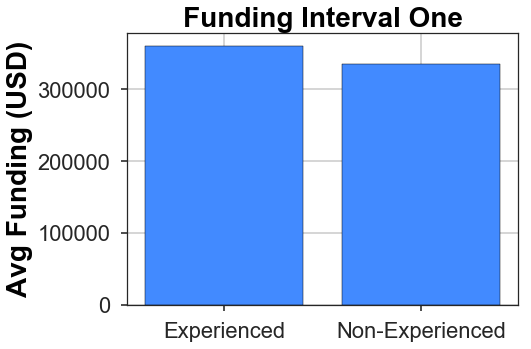

In [48]:
x = np.arange(2)
means = [mean_1, mean_1_noexp]
plt.figure(figsize=(7,5))
plt.bar(x, means, color='#428aff')
plt.xticks(x, ('Experienced', 'Non-Experienced'))
plt.ylabel("Avg Funding (USD)")
plt.title("Funding Interval One")
plt.show()

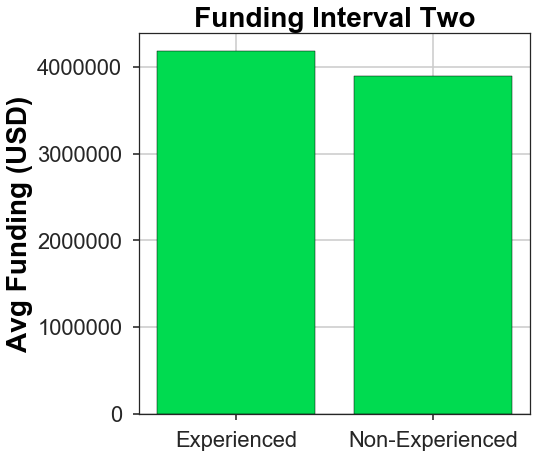

In [49]:
x = np.arange(2)
means = [mean_2, mean_2_noexp]
plt.figure(figsize=(7,7))
plt.bar(x, means, color='#00db50')
plt.xticks(x, ('Experienced', 'Non-Experienced'))
plt.ylabel("Avg Funding (USD)")
plt.title("Funding Interval Two")
plt.show()

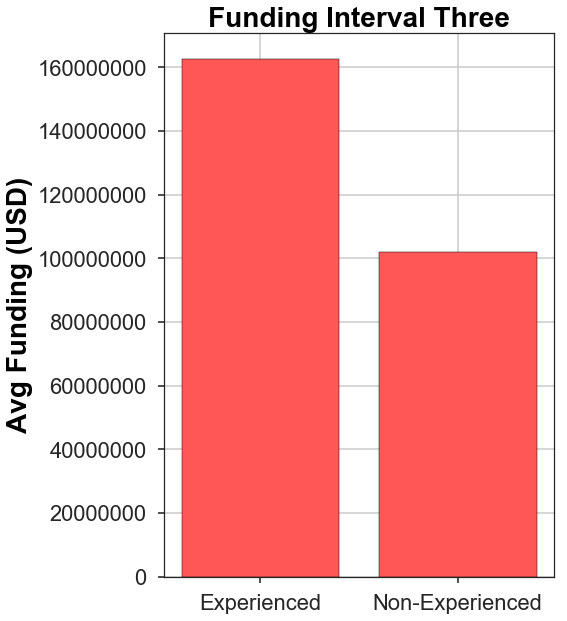

In [50]:
x = np.arange(2)
means = [mean_3, mean_3_noexp]
plt.figure(figsize=(7,10))
plt.bar(x, means, color='#ff5656')
plt.xticks(x, ('Experienced', 'Non-Experienced'))
plt.title("Funding Interval Three")
plt.ylabel("Avg Funding (USD)")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

**Briefly analysing the frequency of funding values...**

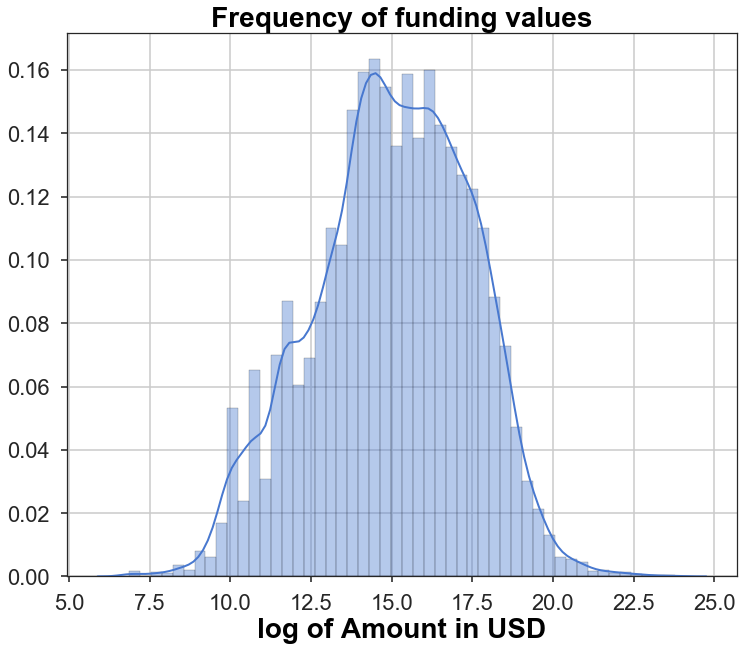

In [51]:
founders_df['USD_log'] = np.log(founders_df['funding_total_usd'] + 1)
plt.figure(figsize=(12,10))
sns.distplot(founders_df['USD_log'].dropna())
plt.xlabel('log of Amount in USD')
plt.title("Frequency of funding values")
plt.show()